# Randomization Test Results

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [15]:
# Changing default directory
os.chdir(Path.cwd().parents[0])

### Functions

In [38]:
def load_test_results(input_combo):
    path = 'randomization_test/combo_{}_test.csv'.format(input_combo)
    df = pd.read_csv(path, index_col=[0, 1])
    return df

In [39]:
def load_obs_metric_change(input_combo, algorithm, metric, dataset):
    path = 'models/region_general_scores.csv'
    region_general_scores = pd.read_csv(path)

    # Slicing values
    cond = (region_general_scores['algorithm'] == algorithm) &\
           (region_general_scores['metric'] == metric) &\
           (region_general_scores['dataset'] == dataset) &\
           (region_general_scores['input_combo'] == input_combo) &\
           (region_general_scores['region'] == 'all_data')

    region_score = region_general_scores.loc[cond, 'region_metric'].squeeze()
    general_score = region_general_scores.loc[cond, 'general_metric'].squeeze()
    
    return 100 * (region_score - general_score) / general_score

In [41]:
def get_p_val(test_metric_change, observed_metric_change):
    cond = test_metric_change <= observed_metric_change
    
    return 1. * cond.sum() / test_metric_change.shape[0]

In [66]:
def plot_test_result(input_combo, ax=None):
    
    # Loading test results
    df = load_test_results(input_combo)
    df['metric_change'] = 100 * (df['cluster_model'] - df['general_model']) / df['general_model']
    
    # Slicing the total model metric change
    idx = pd.IndexSlice
    test_metric_change = df.loc[idx[:, 0], 'metric_change'].to_numpy()
    
    # Loading observed metric change
    algorithm = 'Polynomial'
    metric = 'RMSE'
    dataset = 'test'
    obs_metric_change = load_obs_metric_change(input_combo, algorithm, metric, dataset)
    
    # Computing P-value
    p_val = get_p_val(test_metric_change, obs_metric_change)
    
    bins = 20
    vals, edges = np.histogram(test_metric_change, bins=bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        
    ax.hist(test_metric_change, bins=bins, edgecolor='w', color='skyblue', label='Randomization test')
    
    # Only add the observed value to ticks if it's out of the tick range
    if obs_metric_change < edges.min():
        xticks = np.concatenate([[obs_metric_change], edges])
    else:
        xticks = edges
    
    xticklabels = list(map(lambda x: f'{x:.3f}', xticks))

    ax.axvline(obs_metric_change, color='limegreen', linestyle='--', label='Studied case')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_xlabel('RMSE change %')
    ax.legend()
    ax.text(x=0.7, y=0.7, s=f'P-value = {p_val:.3f}', ha='left', fontsize=12, transform=ax.transAxes)
    
    ax.set_title(f'C{input_combo}')

## Plotting histograms

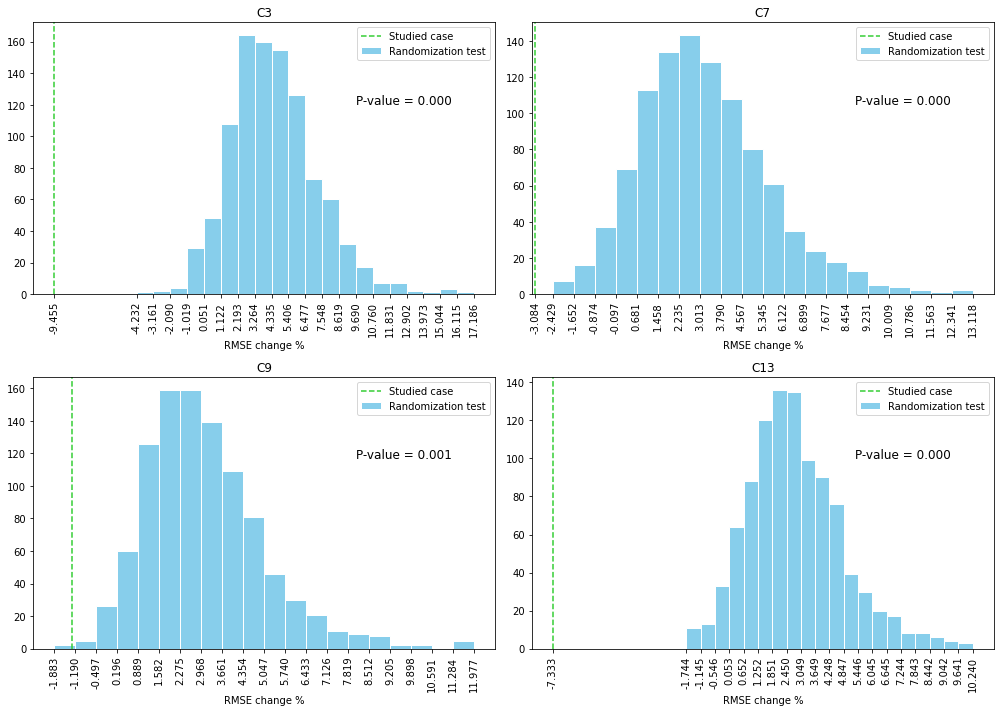

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), tight_layout=True)

for input_combo, ax in zip([3, 7, 9, 13], axs.flatten()):
    plot_test_result(input_combo, ax)

plt.show()